# Age and Gender Prediction

Group 2:
- Miracle Messiri (9030337)
- Jagroop Sandhu


**Dataset**

- Source: https://www.kaggle.com/datasets/jangedoo/utkface-new

The UTKFace dataset is a large-scale face dataset consisting of over 20,000 images. The images cover a wide range of ages and races, including males and females. Each image is a 200x200-pixel JPG file.

Using this dataset, we will attempt to create a model capable of predicting the age and gender of an individual. We will use part one of the cropped variations of the images, of which there are almost 10,000. We will be using 5000 images from the `crop_part1` folder.

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers

### Loading Data

In [2]:
import zipfile
import os


# Path to the uploaded ZIP file
zip_path = "/content/crop_part1.zip"

# Destination directory
output_dir = "/content/crop_part1"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Files extracted to {output_dir}")

Files extracted to /content/crop_part1


In [3]:

# Path to your dataset folder
dataset_path = '/content/crop_part1/crop_part1/'

# List all image files in the directory
image_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

# Process each image
for image_file in image_files:
    try:
        # Open the image
        img = Image.open(image_file)

        img_array = np.array(img)  # Convert to numpy array if needed

        # Display or process the image
        print(f"Processed: {image_file} with shape {img_array.shape}")

    except Exception as e:
        print(f"Error processing {image_file}: {e}")

Streaming output truncated to the last 5000 lines.
Processed: /content/crop_part1/crop_part1/1_1_0_20170109192442932.jpg.chip.jpg with shape (200, 200, 3)
Processed: /content/crop_part1/crop_part1/5_0_2_20161219162450614.jpg.chip.jpg with shape (200, 200, 3)
Processed: /content/crop_part1/crop_part1/37_0_0_20170104172740418.jpg.chip.jpg with shape (200, 200, 3)
Processed: /content/crop_part1/crop_part1/60_0_0_20170109002333882.jpg.chip.jpg with shape (200, 200, 3)
Processed: /content/crop_part1/crop_part1/1_0_2_20161219162808591.jpg.chip.jpg with shape (200, 200, 3)
Processed: /content/crop_part1/crop_part1/4_1_0_20161219230409176.jpg.chip.jpg with shape (200, 200, 3)
Processed: /content/crop_part1/crop_part1/66_0_0_20170111222127534.jpg.chip.jpg with shape (200, 200, 3)
Processed: /content/crop_part1/crop_part1/7_1_2_20161219204222117.jpg.chip.jpg with shape (200, 200, 3)
Processed: /content/crop_part1/crop_part1/9_0_0_20170110220311291.jpg.chip.jpg with shape (200, 200, 3)
Processed:

In [4]:
import tensorflow as tf

images = []
ages = []
genders = []


for i in os.listdir("/content/crop_part1/crop_part1/")[0:5000]:
  split = i.split('_')
  ages.append(int(split[0]))
  genders.append(int(split[1]))
  images.append(Image.open("/content/crop_part1/crop_part1/" + i))

In [5]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
print(df.head())
print(df.shape)

                                              Images  Ages  Genders
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...    52        0
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...    54        1
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...     3        1
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...    48        0
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...     1        0
(5000, 3)


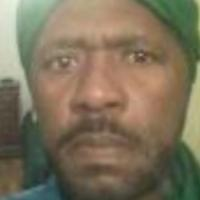

48 0


In [6]:
display(df['Images'][3])
print(df['Ages'][3], df['Genders'][3])

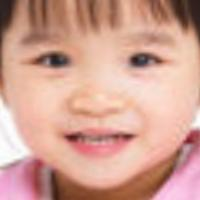

3 1


In [7]:
display(df['Images'][2])
print(df['Ages'][2], df['Genders'][2])

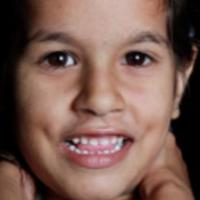

7 1


In [8]:
display(df['Images'][19])
print(df['Ages'][19], df['Genders'][19])

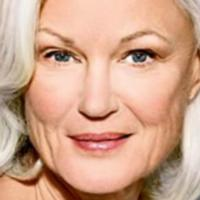

67 1


In [9]:
display(df['Images'][31])
print(df['Ages'][31], df['Genders'][31])

0 corresponds to male, 1 corresponds to female.

### Visualising and prepaing Data

In [10]:
#check for missing values
df.isnull().sum()

,0
Images,0
Ages,0
Genders,0


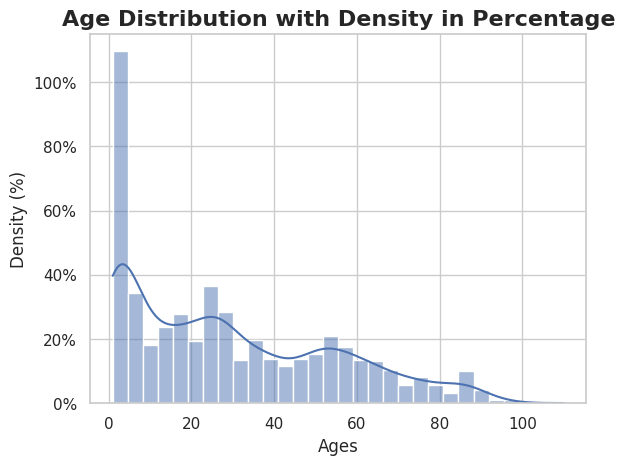

In [11]:
# Create the density plot
sns.set_theme(style="whitegrid")
sns.histplot(df['Ages'], kde=True, bins=30)

# Convert density to percentage on the y-axis
def to_percentage(y, pos):
    return f'{y * 0.1:.0f}%'

from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

# Add labels and title
plt.title("Age Distribution with Density in Percentage", fontsize=16, fontweight='bold')
plt.xlabel("Ages", fontsize=12)
plt.ylabel("Density (%)", fontsize=12)

# Show the plot
plt.show()

There are too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. We will only include a third of the images between these ages to resolve this.

In [12]:
under4s = []

for i in range(len(df)):
  if df['Ages'].iloc[i] <= 4:
    under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

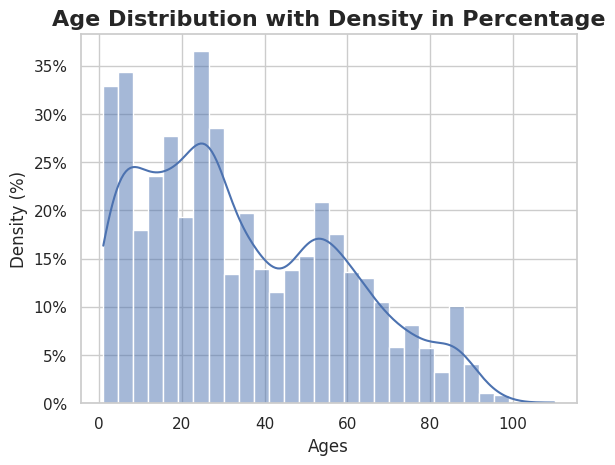

In [13]:
# Create the density plot
sns.set_theme(style="whitegrid")
sns.histplot(df['Ages'], kde=True, bins=30)

# Convert density to percentage on the y-axis
def to_percentage(y, pos):
    return f'{y * 0.1:.0f}%'

from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

# Add labels and title
plt.title("Age Distribution with Density in Percentage", fontsize=16, fontweight='bold')
plt.xlabel("Ages", fontsize=12)
plt.ylabel("Density (%)", fontsize=12)

# Show the plot
plt.show()

This looks so much better! The dataframe now more accurately represents the population. However, there aren't many photos of persons over 80, so the model wouldn't train effectively on such ages. It is ideal to just exclude the over-80s and develop a model that can forecast the ages of persons under 80.

In [14]:
df = df[df['Ages'] < 80]

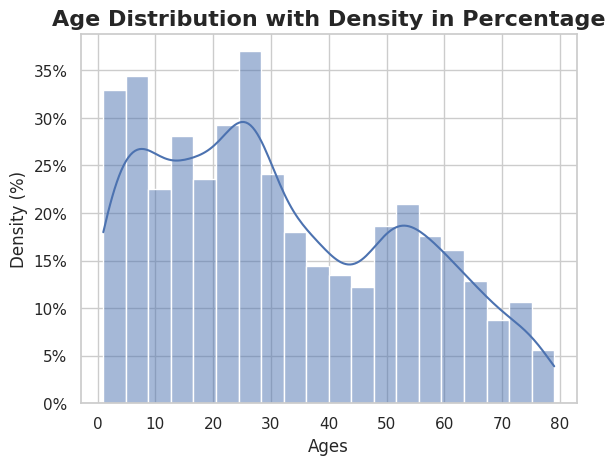

In [15]:
# Create the density plot
sns.set_theme(style="whitegrid")
sns.histplot(df['Ages'], kde=True, bins=20)

# Convert density to percentage on the y-axis
def to_percentage(y, pos):
    return f'{y * 0.1:.0f}%'

from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

# Add labels and title
plt.title("Age Distribution with Density in Percentage", fontsize=16, fontweight='bold')
plt.xlabel("Ages", fontsize=12)
plt.ylabel("Density (%)", fontsize=12)

# Show the plot
plt.show()

Text(0, 0.5, 'Count')

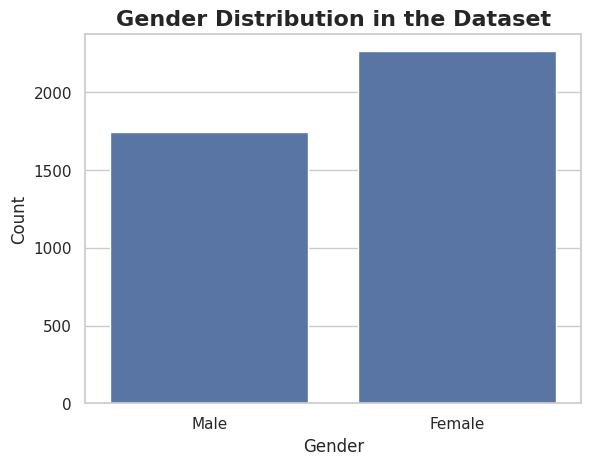

In [16]:
# Replace 0 and 1 with 'Male' and 'Female'
df['Genders'] = df['Genders'].replace({0: 'Male', 1: 'Female'})

# Create the count plot
sns.set_theme(style="whitegrid")
sns.countplot(x='Genders', data=df)

# Add a title to the graph
plt.title("Gender Distribution in the Dataset", fontsize=16, fontweight='bold')

# Add labels for the axes
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12)

Here we can see some imbalance in the gender class. To deal with this imbalance we are going to oversample the minority class


In [17]:
print("Class distribution before balancing:")
print(df['Genders'].value_counts())

Class distribution before balancing:
Genders
Female    2264
Male      1745
Name: count, dtype: int64


In [18]:
import pandas as pd
from sklearn.utils import resample


# Separate majority and minority classes
df_majority = df[df['Genders'] == 'Female']
df_minority = df[df['Genders'] == 'Male']

if not df_minority.empty:  # Check if the minority class has samples
    # Oversample the minority class
    df_minority_oversampled = resample(
        df_minority,
        replace=True,  # Sample with replacement
        n_samples=len(df_majority),  # Match majority size
        random_state=42
    )

    # Combine oversampled minority class with the majority class
    df_balanced = pd.concat([df_majority, df_minority_oversampled])
    print("Class distribution after balancing:")
    print(df_balanced['Genders'].value_counts())
else:
    print("Minority class is empty. Cannot perform oversampling.")

Class distribution after balancing:
Genders
Female    2264
Male      2264
Name: count, dtype: int64


Text(0, 0.5, 'Count')

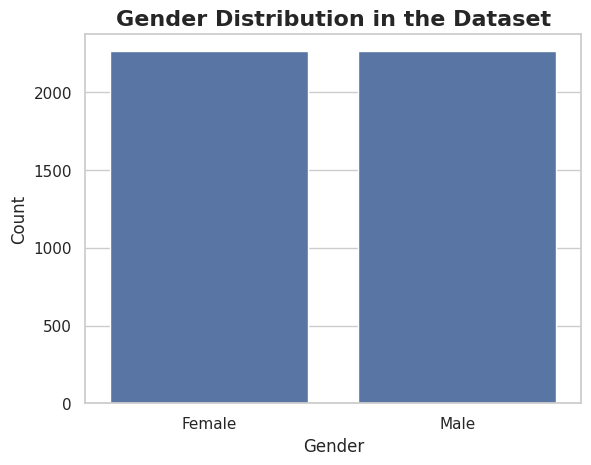

In [19]:
import matplotlib.pyplot as plt

# Replace 0 and 1 with 'Male' and 'Female'
df_balanced['Genders'] = df_balanced['Genders'].replace({0: 'Male', 1: 'Female'})

# Create the count plot
sns.set_theme(style="whitegrid")
sns.countplot(x='Genders', data=df_balanced)

# Add a title to the graph
plt.title("Gender Distribution in the Dataset", fontsize=16, fontweight='bold')

# Add labels for the axes
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12)

In [20]:
df_balanced = df

In [21]:
x = []
y = []

# Replace ''Male and 'Female' with 0 and 1
df['Genders'] = df['Genders'].replace({'Male': 0, 'Female': 1})

#create a new column for resized images
df['Resized_Images'] = None

for i in range(len(df)):
  # Resize the image and store it in the new column
  resized_image = df['Images'].iloc[i].resize((200, 200), Image.LANCZOS)
  df.at[i, 'Resized_Images'] = resized_image # Use df.at for safer assignment

  # Convert the resized image to a Numpy array and append to the list
  ar = np.asarray(resized_image)
  x.append(ar)

  # Extract labels for age and gender
  agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
  y.append(agegen)

# Convert the list of images to a Numpy array
x = np.array(x)

<ipython-input-21-5a85a020da28>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Genders'] = df['Genders'].replace({'Male': 0, 'Female': 1})


### Train Test Split

In [22]:
y_age = df['Ages']
y_gender = df['Genders']

# Fix the mismatch
min_length = min(len(x), len(y_age), len(y_gender))
x, y_age, y_gender = x[:min_length], y_age[:min_length], y_gender[:min_length]

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, random_state=42, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, random_state=42, stratify=y_gender)

### Creating the Models

I'll develop two separate models: one to predict age and one to predict gender. The age model should be able to return continuous numbers that I can round to the nearest integer, whereas the gender model should produce a binary answer.

In [23]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3, 3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
                 optimizer = optimizers.Adam(learning_rate=0.0001))

genmodel = Sequential()
genmodel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3, 3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
                 optimizer = optimizers.Adam(learning_rate=0.0001),
                 metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Training the Models

In [24]:
#data augmentation
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)
test1 = test_datagen.flow(x_test_age, y_test_age, batch_size=32)

callbacks1 = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]

history1 = agemodel.fit(train1, epochs=30, shuffle=True, validation_data=test1, callbacks=callbacks1)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 315ms/step - loss: 791.7835 - val_loss: 479.8692
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 29s 265ms/step - loss: 531.0928 - val_loss: 457.1222
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 29s 267ms/step - loss: 498.7578 - val_loss: 420.1518
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - loss: 468.3063 - val_loss: 392.3717
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - loss: 438.9970 - val_loss: 379.5701
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 269ms/step - loss: 383.3593 - val_loss: 311.2021
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - loss: 372.4402 - val_loss: 282.6201
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 265ms/step - loss: 371.1505 - val_loss: 278.1973
Epoch 9/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 28s 261ms/step - loss: 353.7079 - val_loss: 290.5033
Epoch 10/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 29s 266ms/step - loss: 336.9147 - val_loss: 254.5496
Epoch 11/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 29s 260ms/step - loss: 342.4802 - val_l

#### Plotting results

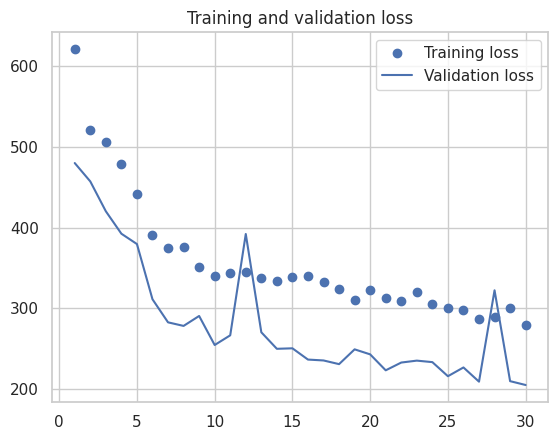

In [25]:
import matplotlib.pyplot as plt

loss = history1.history["loss"]
val_loss = history1.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [26]:
#data augmentation
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)
test2 = test_datagen.flow(x_test_gender, y_test_gender, batch_size=64)

callbacks2 = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss")
]

history2 = genmodel.fit(train2, epochs=30, shuffle=True, validation_data=test2, callbacks=callbacks2)


Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 580ms/step - accuracy: 0.5598 - loss: 0.6793 - val_accuracy: 0.6683 - val_loss: 0.5977
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 473ms/step - accuracy: 0.6637 - loss: 0.6071 - val_accuracy: 0.7045 - val_loss: 0.5699
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 492ms/step - accuracy: 0.7126 - loss: 0.5725 - val_accuracy: 0.7182 - val_loss: 0.5537
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 493ms/step - accuracy: 0.7212 - loss: 0.5613 - val_accuracy: 0.7456 - val_loss: 0.5290
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 497ms/step - accuracy: 0.7430 - loss: 0.5409 - val_accuracy: 0.7594 - val_loss: 0.5066
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 478ms/step - accuracy: 0.7604 - loss: 0.5065 - val_accuracy: 0.7693 - val_loss: 0.4762
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 470ms/step - accuracy: 0.7629 - loss: 0.5042 - val_accuracy: 0.7656 - val_loss: 0.4749
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 489ms/step - accuracy: 0.7772 - loss: 0.4824 - val_accu

#### Plotting results

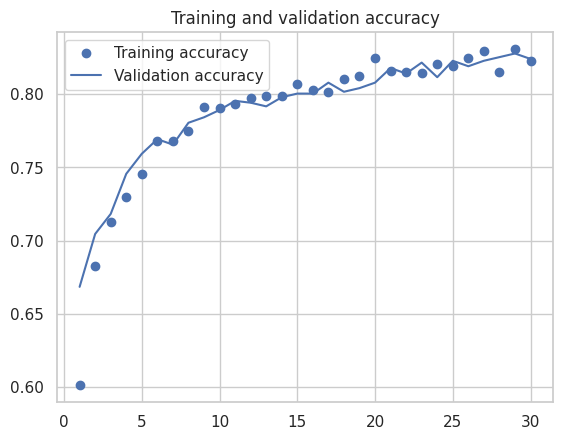

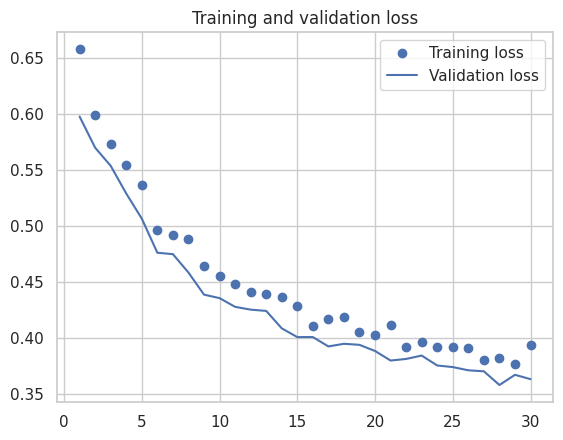

In [27]:
import matplotlib.pyplot as plt

acc = history2.history["accuracy"]
val_acc = history2.history["val_accuracy"]
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Evaluating the models

In [28]:
# Path to the uploaded ZIP file
test_zip_path = "/content/test_data.zip"

# Destination directory
test_output_dir = "/content/test_data"

# Create output directory if it doesn't exist
os.makedirs(test_output_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_output_dir)

print(f"Files extracted to {test_output_dir}")

Files extracted to /content/test_data


In [29]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.LANCZOS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.LANCZOS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.LANCZOS)

    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)

    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'

    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.LANCZOS)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
Age: 45 
 Gender: male


<ipython-input-29-3b6256a93a27>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Age:', int(age), '\n Gender:', gender)


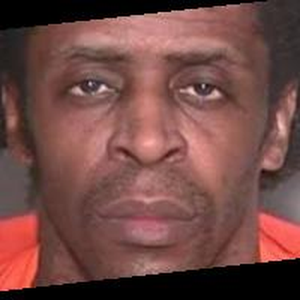

In [31]:
process_and_predict('/content/test_data/test_data/50_0_1_20170117173418899.jpg.chip.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Age: 68 
 Gender: male


<ipython-input-29-3b6256a93a27>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Age:', int(age), '\n Gender:', gender)


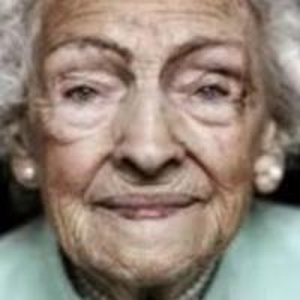

In [32]:
process_and_predict('/content/test_data/test_data/100_1_0_20170119212053665.jpg.chip.jpg')

#### Evaluating the Age model

In [33]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the model
test_age_model = load_model("./models/convnet_from_scratch_with_augmentation1.keras")

# Path to image folder
image_folder = "/content/test_data/test_data/"

# Preprocessing function
def preprocess_image(image_path, target_size):
    """Loads and preprocesses an image."""
    img = load_img(image_path, target_size=target_size)  # Resize image
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Iterate over images in the folder
target_size = (200, 200)  # Replace with the input size of your model
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', 'jpeg'))]

predictions = []
for image_path in image_files:
    # Preprocess the image
    img_preprocessed = preprocess_image(image_path, target_size)

    # Make prediction
    pred = test_age_model.predict(img_preprocessed)
    predictions.append((image_path, pred))

# Print results
for image_path, pred in predictions:
    print(f"Image: {image_path}, Prediction: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: /content/test_data/test_data/100_1_0_20170119212053665.jpg.chip.jpg, Prediction: [[68.157425]]
Image: /content/test_data/test_data/70_0_0_20170117172840833.jpg.chip.jpg, Prediction: [[49.555347]]
Image: /content/test_data/test_data/50_0_1_20170117173418899.jpg.chip.jpg, Prediction: [[45.979454]]
Image: /content/test_data/test_data/24_0_4_20170117145146997.jpg.chip.jpg, Prediction: [[20.586218]]
Image: /content/test_data/test_data/37_0_0_20170117164409579.jpg.chip.jpg, Prediction: [[35.519295]]
Image: /content/test_data/test_data/1_0_0_20161219212409141.jpg.chip.jpg, Prediction: [[21.331036]]


In [34]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the model
test_age_model = load_model("./models/convnet_from_scratch_with_augmentation1.keras")

# Path to image folder
image_folder = "/content/test_data/test_data/"

# Preprocessing function
def preprocess_image(image_path, target_size):
    """Loads and preprocesses an image."""
    img = load_img(image_path, target_size=target_size)  # Resize image
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Iterate over images in the folder
target_size = (200, 200)  # Replace with the input size of your model
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', 'jpeg'))]

true_values = []
predicted_values = []

for image_path in image_files:
    # Get the base name (e.g., "50_image1.jpg")
    image_name = os.path.basename(image_path)

    # Extract ground truth from the file name
    try:
        ground_truth_value = int(image_name.split('_')[0])  # Split by '_' and get the first part
        true_values.append(ground_truth_value)  # Append ground truth

        # Preprocess the image
        img_preprocessed = preprocess_image(image_path, target_size)

        # Make prediction
        pred = test_age_model.predict(img_preprocessed)
        predicted_values.append(pred[0][0])  # Assuming regression output is a single value
    except ValueError:
        print(f"Skipping file {image_name} as it doesn't contain a valid ground truth value.")

# Calculate metrics
mse = mean_squared_error(true_values, predicted_values)
mae = mean_absolute_error(true_values, predicted_values)
rmse = np.sqrt(mse)

# Print results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Mean Squared Error (MSE): 312.55
Mean Absolute Error (MAE): 13.59
Root Mean Squared Error (RMSE): 17.68


#### Evaluating the gender model

In [35]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the model
test_gender_model = load_model("./models/convnet_from_scratch_with_augmentation2.keras")

# Path to image folder
image_folder = "/content/test_data/test_data/"

# Preprocessing function
def preprocess_image(image_path, target_size):
    """Loads and preprocesses an image."""
    img = load_img(image_path, target_size=target_size)  # Resize image
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Iterate over images in the folder
target_size = (200, 200)  # Replace with the input size of your model
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', 'jpeg'))]

predictions = []
for image_path in image_files:
    # Preprocess the image
    img_preprocessed = preprocess_image(image_path, target_size)

    # Make prediction
    pred = test_gender_model.predict(img_preprocessed)
    predictions.append((image_path, pred))

# Print results
for image_path, pred in predictions:
    print(f"Image: {image_path}, Prediction: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: /content/test_data/test_data/100_1_0_20170119212053665.jpg.chip.jpg, Prediction: [[0.14565767]]
Image: /content/test_data/test_data/70_0_0_20170117172840833.jpg.chip.jpg, Prediction: [[0.3029982]]
Image: /content/test_data/test_data/50_0_1_20170117173418899.jpg.chip.jpg, Prediction: [[0.10581236]]
Image: /content/test_data/test_data/24_0_4_20170117145146997.jpg.chip.jpg, Prediction: [[0.95197546]]
Image: /content/test_data/test_data/37_0_0_20170117164409579.jpg.chip.jpg, Prediction: [[0.01436503]]
Image: /content/test_data/test_data/1_0_0_20161219212409141.jpg.chip.jpg, Prediction: [[0.42972288]]


In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define a margin of error for correct classification
margin_of_error = 5  # Example: Prediction is correct if within ±5 of the true value

# Convert regression outputs to binary classification (correct/incorrect)
classification_true = []
classification_pred = []

for true, pred in zip(true_values, predicted_values):
    is_correct = abs(true - pred) <= margin_of_error  # Correct if within margin
    classification_true.append(1)  # 1 = true label is "correct"
    classification_pred.append(1 if is_correct else 0)  # 1 = "predicted correct"

# Calculate classification metrics
accuracy = accuracy_score(classification_true, classification_pred)
precision = precision_score(classification_true, classification_pred)
recall = recall_score(classification_true, classification_pred)
f1 = f1_score(classification_true, classification_pred)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.50
Precision: 1.00
Recall: 0.50
F1 Score: 0.67


In [41]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report

# Test data
true_genders = y_train_gender.values.astype(int)  # Ensure binary labels are integers
true_ages = y_train_age.values

# Gender naive model: Predict majority class
naive_gender_pred = [np.bincount(true_genders).argmax()] * len(true_genders)

# Age naive model: Predict mean age
mean_age = np.mean(true_ages)
naive_age_pred = [mean_age] * len(true_ages)

# Evaluate Naive Models
gender_accuracy = accuracy_score(true_genders, naive_gender_pred)
age_mae = mean_absolute_error(true_ages, naive_age_pred)

# Confusion Matrix for Gender Prediction
conf_matrix = confusion_matrix(true_genders, naive_gender_pred)

# Classification Report for Gender Prediction
class_report = classification_report(true_genders, naive_gender_pred, target_names=["Female", "Male"])

print("Naive Gender Accuracy:", gender_accuracy)
print("Naive Age MAE:", age_mae)
#print("Confusion Matrix for Gender Prediction:\n", conf_matrix)
print("Classification Report for Gender Prediction:\n", class_report)


Naive Gender Accuracy: 0.5647022139070783
Naive Age MAE: 18.048873833733484
Classification Report for Gender Prediction:
               precision    recall  f1-score   support

      Female       0.00      0.00      0.00      1396
        Male       0.56      1.00      0.72      1811

    accuracy                           0.56      3207
   macro avg       0.28      0.50      0.36      3207
weighted avg       0.32      0.56      0.41      3207



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
